# 6.4 Efficient GAN


In [1]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


# Generatorの実装



In [3]:
class Generator(nn.Module):

    def __init__(self, z_dim=20):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=1,
                               kernel_size=4, stride=2, padding=1),
            nn.Tanh())

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)

        out = out.view(z.shape[0], 128, 7, 7)
        out = self.layer3(out)
        out = self.last(out)

        return out


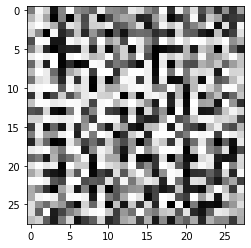

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20)
G.train()

input_z = torch.randn(2, 20)

fake_images = G(input_z)  # torch.Size([2, 1, 28, 28])
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


# Discriminatorの実装

In [5]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()

        self.x_layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.x_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        self.z_layer1 = nn.Linear(z_dim, 512)

        self.last1 = nn.Sequential(
            nn.Linear(3648, 1024),
            nn.LeakyReLU(0.1, inplace=True))

        self.last2 = nn.Linear(1024, 1)

    def forward(self, x, z):

        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)

        z = z.view(z.shape[0], -1)
        z_out = self.z_layer1(z)

        x_out = x_out.view(-1, 64 * 7 * 7)
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)

        feature = out  
        feature = feature.view(feature.size()[0], -1)  

        out = self.last2(out)

        return out, feature


In [6]:
D = Discriminator(z_dim=20)

input_z = torch.randn(2, 20)
fake_images = G(input_z)

d_out, _ = D(fake_images, input_z)

print(nn.Sigmoid()(d_out))


tensor([[0.4322],
        [0.4629]], grad_fn=<SigmoidBackward>)


# Encoder

In [7]:
class Encoder(nn.Module):

    def __init__(self, z_dim=20):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3,
                      stride=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Linear(128 * 7 * 7, z_dim)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        out = out.view(-1, 128 * 7 * 7)
        out = self.last(out)

        return out


In [8]:
E = Encoder(z_dim=20)

x = fake_images 

z = E(x)

print(z.shape)
print(z)


torch.Size([2, 20])
tensor([[-0.0669, -0.2844, -0.3601,  0.1404, -0.2922, -0.4834, -0.0025,  0.0258,
         -0.1298, -0.2612, -0.4292, -0.2584, -0.6141, -0.1440,  0.1142,  0.2175,
          0.0730,  0.0323, -0.7176, -0.7410],
        [ 0.4822,  0.3682, -0.0647, -0.0773,  0.0989,  0.3012,  0.8054,  0.4398,
          1.0848, -0.2809,  0.0619, -0.3179, -0.2963, -0.1192,  0.6562, -0.1707,
          0.1287, -0.6156,  0.3127, -0.4818]], grad_fn=<AddmmBackward>)


# DataLoader

In [9]:
def make_datapath_list():

    train_img_list = list()
    
    for img_idx in range(200):
        img_path = "./data/img_78_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


In [10]:
class ImageTransform():

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)


In [11]:
class GAN_Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):

        img_path = self.file_list[index]
        img = Image.open(img_path) 

        img_transformed = self.transform(img)

        return img_transformed


In [12]:
# DataLoader

train_img_list=make_datapath_list()

# Dataset
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoader
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader) 
imges = next(batch_iterator)
print(imges.size())  # torch.Size([64, 1, 64, 64])


torch.Size([64, 1, 28, 28])


In [13]:
def train_model(G, D, E, dataloader, num_epochs):

    # GPU
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    lr_ge = 0.0001
    lr_d = 0.0001/4
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])

    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    z_dim = 20
    mini_batch_size = 64

    G.to(device)
    E.to(device)
    D.to(device)

    G.train()  
    E.train()  
    D.train()  

    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    iteration = 1
    logs = []

    for epoch in range(num_epochs):

        t_epoch_start = time.time()
        epoch_g_loss = 0.0  
        epoch_e_loss = 0.0 
        epoch_d_loss = 0.0  

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        for imges in dataloader:

            if imges.size()[0] == 1:
                continue

            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            imges = imges.to(device)

            # --------------------
            # 1. Discriminator
            # --------------------
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator
            # --------------------
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            g_loss = criterion(d_out_fake.view(-1), label_real)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. Encoder
            # --------------------
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            e_loss = criterion(d_out_real.view(-1), label_fake)

            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()

            # --------------------
            # 4. 
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            iteration += 1

        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||Epoch_E_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D, E


In [14]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        m.bias.data.fill_(0)


G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (x_layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (x_layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (z_layer1): Linear(in_features=20, out_features=512, bias=True)
  (last1): Sequential(
    (0): Linear(in_features=3648, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (last2): Linear(in_features=1024, out_features=1, bias=True)
)

In [15]:
num_epochs = 1500
G_update, D_update, E_update = train_model(
    G, D, E, dataloader=train_dataloader, num_epochs=num_epochs)


-------------
Epoch 0/1500
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.1488 ||Epoch_G_Loss:0.0787 ||Epoch_E_Loss:0.0765
timer:  1.3737 sec.
-------------
Epoch 1/1500
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.1449 ||Epoch_G_Loss:0.0812 ||Epoch_E_Loss:0.0781
timer:  0.2586 sec.
-------------
Epoch 2/1500
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.1409 ||Epoch_G_Loss:0.0830 ||Epoch_E_Loss:0.0804
timer:  0.2458 sec.
-------------
Epoch 3/1500
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.1367 ||Epoch_G_Loss:0.0850 ||Epoch_E_Loss:0.0836
timer:  0.2662 sec.
-------------
Epoch 4/1500
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.1336 ||Epoch_G_Loss:0.0867 ||Epoch_E_Loss:0.0854
timer:  0.2413 sec.
-------------
Epoch 5/1500
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.1316 ||Epoch_G_Loss:0.0884 ||Epoch_E_Loss:0.0870
timer:  0.2440 sec.
-------------
Epoch 6/1500
-------------
（train）
---

-------------
epoch 52 || Epoch_D_Loss:0.0098 ||Epoch_G_Loss:0.3871 ||Epoch_E_Loss:0.3697
timer:  0.2441 sec.
-------------
Epoch 53/1500
-------------
（train）
-------------
epoch 53 || Epoch_D_Loss:0.0093 ||Epoch_G_Loss:0.3882 ||Epoch_E_Loss:0.3698
timer:  0.2516 sec.
-------------
Epoch 54/1500
-------------
（train）
-------------
epoch 54 || Epoch_D_Loss:0.0109 ||Epoch_G_Loss:0.3880 ||Epoch_E_Loss:0.3446
timer:  0.2420 sec.
-------------
Epoch 55/1500
-------------
（train）
-------------
epoch 55 || Epoch_D_Loss:0.0107 ||Epoch_G_Loss:0.3849 ||Epoch_E_Loss:0.3544
timer:  0.2489 sec.
-------------
Epoch 56/1500
-------------
（train）
-------------
epoch 56 || Epoch_D_Loss:0.0086 ||Epoch_G_Loss:0.3941 ||Epoch_E_Loss:0.3850
timer:  0.2425 sec.
-------------
Epoch 57/1500
-------------
（train）
-------------
epoch 57 || Epoch_D_Loss:0.0079 ||Epoch_G_Loss:0.3899 ||Epoch_E_Loss:0.3952
timer:  0.2414 sec.
-------------
Epoch 58/1500
-------------
（train）
-------------
epoch 58 || Epoch_D_Loss:0

-------------
epoch 104 || Epoch_D_Loss:0.0231 ||Epoch_G_Loss:0.3290 ||Epoch_E_Loss:0.3504
timer:  0.2510 sec.
-------------
Epoch 105/1500
-------------
（train）
-------------
epoch 105 || Epoch_D_Loss:0.0325 ||Epoch_G_Loss:0.3160 ||Epoch_E_Loss:0.3093
timer:  0.2973 sec.
-------------
Epoch 106/1500
-------------
（train）
-------------
epoch 106 || Epoch_D_Loss:0.0358 ||Epoch_G_Loss:0.2938 ||Epoch_E_Loss:0.3465
timer:  0.2809 sec.
-------------
Epoch 107/1500
-------------
（train）
-------------
epoch 107 || Epoch_D_Loss:0.0279 ||Epoch_G_Loss:0.3264 ||Epoch_E_Loss:0.3316
timer:  0.2420 sec.
-------------
Epoch 108/1500
-------------
（train）
-------------
epoch 108 || Epoch_D_Loss:0.0307 ||Epoch_G_Loss:0.3079 ||Epoch_E_Loss:0.3382
timer:  0.2451 sec.
-------------
Epoch 109/1500
-------------
（train）
-------------
epoch 109 || Epoch_D_Loss:0.0390 ||Epoch_G_Loss:0.2950 ||Epoch_E_Loss:0.3188
timer:  0.2527 sec.
-------------
Epoch 110/1500
-------------
（train）
-------------
epoch 110 || E

-------------
epoch 155 || Epoch_D_Loss:0.0710 ||Epoch_G_Loss:0.2049 ||Epoch_E_Loss:0.2195
timer:  0.2449 sec.
-------------
Epoch 156/1500
-------------
（train）
-------------
epoch 156 || Epoch_D_Loss:0.0965 ||Epoch_G_Loss:0.1680 ||Epoch_E_Loss:0.1957
timer:  0.2648 sec.
-------------
Epoch 157/1500
-------------
（train）
-------------
epoch 157 || Epoch_D_Loss:0.1070 ||Epoch_G_Loss:0.1524 ||Epoch_E_Loss:0.1859
timer:  0.2718 sec.
-------------
Epoch 158/1500
-------------
（train）
-------------
epoch 158 || Epoch_D_Loss:0.1240 ||Epoch_G_Loss:0.1663 ||Epoch_E_Loss:0.1612
timer:  0.2506 sec.
-------------
Epoch 159/1500
-------------
（train）
-------------
epoch 159 || Epoch_D_Loss:0.0952 ||Epoch_G_Loss:0.1668 ||Epoch_E_Loss:0.1783
timer:  0.2434 sec.
-------------
Epoch 160/1500
-------------
（train）
-------------
epoch 160 || Epoch_D_Loss:0.0880 ||Epoch_G_Loss:0.1743 ||Epoch_E_Loss:0.1797
timer:  0.2498 sec.
-------------
Epoch 161/1500
-------------
（train）
-------------
epoch 161 || E

-------------
epoch 206 || Epoch_D_Loss:0.1126 ||Epoch_G_Loss:0.1530 ||Epoch_E_Loss:0.1513
timer:  0.2550 sec.
-------------
Epoch 207/1500
-------------
（train）
-------------
epoch 207 || Epoch_D_Loss:0.1125 ||Epoch_G_Loss:0.1654 ||Epoch_E_Loss:0.1502
timer:  0.2460 sec.
-------------
Epoch 208/1500
-------------
（train）
-------------
epoch 208 || Epoch_D_Loss:0.0962 ||Epoch_G_Loss:0.1463 ||Epoch_E_Loss:0.1659
timer:  0.2390 sec.
-------------
Epoch 209/1500
-------------
（train）
-------------
epoch 209 || Epoch_D_Loss:0.1055 ||Epoch_G_Loss:0.1768 ||Epoch_E_Loss:0.1540
timer:  0.2508 sec.
-------------
Epoch 210/1500
-------------
（train）
-------------
epoch 210 || Epoch_D_Loss:0.1001 ||Epoch_G_Loss:0.1660 ||Epoch_E_Loss:0.1618
timer:  0.2424 sec.
-------------
Epoch 211/1500
-------------
（train）
-------------
epoch 211 || Epoch_D_Loss:0.1094 ||Epoch_G_Loss:0.1685 ||Epoch_E_Loss:0.1512
timer:  0.2563 sec.
-------------
Epoch 212/1500
-------------
（train）
-------------
epoch 212 || E

-------------
epoch 257 || Epoch_D_Loss:0.1225 ||Epoch_G_Loss:0.1107 ||Epoch_E_Loss:0.1386
timer:  0.2576 sec.
-------------
Epoch 258/1500
-------------
（train）
-------------
epoch 258 || Epoch_D_Loss:0.1472 ||Epoch_G_Loss:0.1155 ||Epoch_E_Loss:0.1221
timer:  0.2481 sec.
-------------
Epoch 259/1500
-------------
（train）
-------------
epoch 259 || Epoch_D_Loss:0.1597 ||Epoch_G_Loss:0.1097 ||Epoch_E_Loss:0.1143
timer:  0.2443 sec.
-------------
Epoch 260/1500
-------------
（train）
-------------
epoch 260 || Epoch_D_Loss:0.1669 ||Epoch_G_Loss:0.1062 ||Epoch_E_Loss:0.1124
timer:  0.2426 sec.
-------------
Epoch 261/1500
-------------
（train）
-------------
epoch 261 || Epoch_D_Loss:0.1543 ||Epoch_G_Loss:0.1094 ||Epoch_E_Loss:0.1186
timer:  0.2498 sec.
-------------
Epoch 262/1500
-------------
（train）
-------------
epoch 262 || Epoch_D_Loss:0.1360 ||Epoch_G_Loss:0.1087 ||Epoch_E_Loss:0.1266
timer:  0.2443 sec.
-------------
Epoch 263/1500
-------------
（train）
-------------
epoch 263 || E

-------------
epoch 308 || Epoch_D_Loss:0.1047 ||Epoch_G_Loss:0.1436 ||Epoch_E_Loss:0.1408
timer:  0.2477 sec.
-------------
Epoch 309/1500
-------------
（train）
-------------
epoch 309 || Epoch_D_Loss:0.1231 ||Epoch_G_Loss:0.1191 ||Epoch_E_Loss:0.1312
timer:  0.2467 sec.
-------------
Epoch 310/1500
-------------
（train）
-------------
epoch 310 || Epoch_D_Loss:0.1585 ||Epoch_G_Loss:0.1006 ||Epoch_E_Loss:0.1064
timer:  0.2612 sec.
-------------
Epoch 311/1500
-------------
（train）
-------------
epoch 311 || Epoch_D_Loss:0.1966 ||Epoch_G_Loss:0.0762 ||Epoch_E_Loss:0.0975
timer:  0.2886 sec.
-------------
Epoch 312/1500
-------------
（train）
-------------
epoch 312 || Epoch_D_Loss:0.1387 ||Epoch_G_Loss:0.1198 ||Epoch_E_Loss:0.1212
timer:  0.2555 sec.
-------------
Epoch 313/1500
-------------
（train）
-------------
epoch 313 || Epoch_D_Loss:0.1305 ||Epoch_G_Loss:0.1197 ||Epoch_E_Loss:0.1287
timer:  0.2502 sec.
-------------
Epoch 314/1500
-------------
（train）
-------------
epoch 314 || E

-------------
epoch 359 || Epoch_D_Loss:0.1322 ||Epoch_G_Loss:0.1094 ||Epoch_E_Loss:0.1181
timer:  0.2447 sec.
-------------
Epoch 360/1500
-------------
（train）
-------------
epoch 360 || Epoch_D_Loss:0.1486 ||Epoch_G_Loss:0.0905 ||Epoch_E_Loss:0.1068
timer:  0.2481 sec.
-------------
Epoch 361/1500
-------------
（train）
-------------
epoch 361 || Epoch_D_Loss:0.1883 ||Epoch_G_Loss:0.0829 ||Epoch_E_Loss:0.0899
timer:  0.2418 sec.
-------------
Epoch 362/1500
-------------
（train）
-------------
epoch 362 || Epoch_D_Loss:0.1883 ||Epoch_G_Loss:0.0756 ||Epoch_E_Loss:0.0897
timer:  0.2426 sec.
-------------
Epoch 363/1500
-------------
（train）
-------------
epoch 363 || Epoch_D_Loss:0.1790 ||Epoch_G_Loss:0.0847 ||Epoch_E_Loss:0.0966
timer:  0.2424 sec.
-------------
Epoch 364/1500
-------------
（train）
-------------
epoch 364 || Epoch_D_Loss:0.1518 ||Epoch_G_Loss:0.0940 ||Epoch_E_Loss:0.1112
timer:  0.2411 sec.
-------------
Epoch 365/1500
-------------
（train）
-------------
epoch 365 || E

-------------
epoch 410 || Epoch_D_Loss:0.1917 ||Epoch_G_Loss:0.0684 ||Epoch_E_Loss:0.0816
timer:  0.2449 sec.
-------------
Epoch 411/1500
-------------
（train）
-------------
epoch 411 || Epoch_D_Loss:0.1831 ||Epoch_G_Loss:0.0739 ||Epoch_E_Loss:0.0849
timer:  0.2411 sec.
-------------
Epoch 412/1500
-------------
（train）
-------------
epoch 412 || Epoch_D_Loss:0.1673 ||Epoch_G_Loss:0.0812 ||Epoch_E_Loss:0.0950
timer:  0.2420 sec.
-------------
Epoch 413/1500
-------------
（train）
-------------
epoch 413 || Epoch_D_Loss:0.1430 ||Epoch_G_Loss:0.0874 ||Epoch_E_Loss:0.1075
timer:  0.2426 sec.
-------------
Epoch 414/1500
-------------
（train）
-------------
epoch 414 || Epoch_D_Loss:0.1351 ||Epoch_G_Loss:0.0994 ||Epoch_E_Loss:0.1097
timer:  0.2664 sec.
-------------
Epoch 415/1500
-------------
（train）
-------------
epoch 415 || Epoch_D_Loss:0.1262 ||Epoch_G_Loss:0.1164 ||Epoch_E_Loss:0.1158
timer:  0.2478 sec.
-------------
Epoch 416/1500
-------------
（train）
-------------
epoch 416 || E

-------------
epoch 461 || Epoch_D_Loss:0.1470 ||Epoch_G_Loss:0.0898 ||Epoch_E_Loss:0.0939
timer:  0.2624 sec.
-------------
Epoch 462/1500
-------------
（train）
-------------
epoch 462 || Epoch_D_Loss:0.1517 ||Epoch_G_Loss:0.0821 ||Epoch_E_Loss:0.0952
timer:  0.2612 sec.
-------------
Epoch 463/1500
-------------
（train）
-------------
epoch 463 || Epoch_D_Loss:0.1539 ||Epoch_G_Loss:0.0895 ||Epoch_E_Loss:0.0904
timer:  0.2470 sec.
-------------
Epoch 464/1500
-------------
（train）
-------------
epoch 464 || Epoch_D_Loss:0.1449 ||Epoch_G_Loss:0.0899 ||Epoch_E_Loss:0.0999
timer:  0.2597 sec.
-------------
Epoch 465/1500
-------------
（train）
-------------
epoch 465 || Epoch_D_Loss:0.1486 ||Epoch_G_Loss:0.0939 ||Epoch_E_Loss:0.0943
timer:  0.2653 sec.
-------------
Epoch 466/1500
-------------
（train）
-------------
epoch 466 || Epoch_D_Loss:0.1410 ||Epoch_G_Loss:0.0943 ||Epoch_E_Loss:0.1032
timer:  0.2463 sec.
-------------
Epoch 467/1500
-------------
（train）
-------------
epoch 467 || E

-------------
epoch 512 || Epoch_D_Loss:0.1472 ||Epoch_G_Loss:0.0927 ||Epoch_E_Loss:0.0977
timer:  0.2646 sec.
-------------
Epoch 513/1500
-------------
（train）
-------------
epoch 513 || Epoch_D_Loss:0.1287 ||Epoch_G_Loss:0.1010 ||Epoch_E_Loss:0.1109
timer:  0.2530 sec.
-------------
Epoch 514/1500
-------------
（train）
-------------
epoch 514 || Epoch_D_Loss:0.1262 ||Epoch_G_Loss:0.0991 ||Epoch_E_Loss:0.1117
timer:  0.2501 sec.
-------------
Epoch 515/1500
-------------
（train）
-------------
epoch 515 || Epoch_D_Loss:0.1323 ||Epoch_G_Loss:0.0939 ||Epoch_E_Loss:0.1075
timer:  0.2581 sec.
-------------
Epoch 516/1500
-------------
（train）
-------------
epoch 516 || Epoch_D_Loss:0.1421 ||Epoch_G_Loss:0.0969 ||Epoch_E_Loss:0.1006
timer:  0.2431 sec.
-------------
Epoch 517/1500
-------------
（train）
-------------
epoch 517 || Epoch_D_Loss:0.1417 ||Epoch_G_Loss:0.0941 ||Epoch_E_Loss:0.1000
timer:  0.2634 sec.
-------------
Epoch 518/1500
-------------
（train）
-------------
epoch 518 || E

-------------
epoch 563 || Epoch_D_Loss:0.1421 ||Epoch_G_Loss:0.0891 ||Epoch_E_Loss:0.0977
timer:  0.2704 sec.
-------------
Epoch 564/1500
-------------
（train）
-------------
epoch 564 || Epoch_D_Loss:0.1411 ||Epoch_G_Loss:0.0860 ||Epoch_E_Loss:0.0998
timer:  0.2611 sec.
-------------
Epoch 565/1500
-------------
（train）
-------------
epoch 565 || Epoch_D_Loss:0.1318 ||Epoch_G_Loss:0.0924 ||Epoch_E_Loss:0.1049
timer:  0.2840 sec.
-------------
Epoch 566/1500
-------------
（train）
-------------
epoch 566 || Epoch_D_Loss:0.1364 ||Epoch_G_Loss:0.0935 ||Epoch_E_Loss:0.1000
timer:  0.2450 sec.
-------------
Epoch 567/1500
-------------
（train）
-------------
epoch 567 || Epoch_D_Loss:0.1439 ||Epoch_G_Loss:0.0875 ||Epoch_E_Loss:0.0971
timer:  0.2520 sec.
-------------
Epoch 568/1500
-------------
（train）
-------------
epoch 568 || Epoch_D_Loss:0.1349 ||Epoch_G_Loss:0.0902 ||Epoch_E_Loss:0.1006
timer:  0.2506 sec.
-------------
Epoch 569/1500
-------------
（train）
-------------
epoch 569 || E

-------------
epoch 614 || Epoch_D_Loss:0.1404 ||Epoch_G_Loss:0.0912 ||Epoch_E_Loss:0.0994
timer:  0.2433 sec.
-------------
Epoch 615/1500
-------------
（train）
-------------
epoch 615 || Epoch_D_Loss:0.1405 ||Epoch_G_Loss:0.0942 ||Epoch_E_Loss:0.0979
timer:  0.2473 sec.
-------------
Epoch 616/1500
-------------
（train）
-------------
epoch 616 || Epoch_D_Loss:0.1414 ||Epoch_G_Loss:0.0850 ||Epoch_E_Loss:0.1016
timer:  0.2771 sec.
-------------
Epoch 617/1500
-------------
（train）
-------------
epoch 617 || Epoch_D_Loss:0.1403 ||Epoch_G_Loss:0.0931 ||Epoch_E_Loss:0.1014
timer:  0.2649 sec.
-------------
Epoch 618/1500
-------------
（train）
-------------
epoch 618 || Epoch_D_Loss:0.1243 ||Epoch_G_Loss:0.1033 ||Epoch_E_Loss:0.1134
timer:  0.2469 sec.
-------------
Epoch 619/1500
-------------
（train）
-------------
epoch 619 || Epoch_D_Loss:0.1207 ||Epoch_G_Loss:0.1041 ||Epoch_E_Loss:0.1177
timer:  0.2477 sec.
-------------
Epoch 620/1500
-------------
（train）
-------------
epoch 620 || E

-------------
epoch 665 || Epoch_D_Loss:0.1309 ||Epoch_G_Loss:0.1058 ||Epoch_E_Loss:0.1063
timer:  0.2688 sec.
-------------
Epoch 666/1500
-------------
（train）
-------------
epoch 666 || Epoch_D_Loss:0.1206 ||Epoch_G_Loss:0.1025 ||Epoch_E_Loss:0.1173
timer:  0.2756 sec.
-------------
Epoch 667/1500
-------------
（train）
-------------
epoch 667 || Epoch_D_Loss:0.1398 ||Epoch_G_Loss:0.0945 ||Epoch_E_Loss:0.0995
timer:  0.2567 sec.
-------------
Epoch 668/1500
-------------
（train）
-------------
epoch 668 || Epoch_D_Loss:0.1561 ||Epoch_G_Loss:0.0851 ||Epoch_E_Loss:0.0919
timer:  0.2440 sec.
-------------
Epoch 669/1500
-------------
（train）
-------------
epoch 669 || Epoch_D_Loss:0.1514 ||Epoch_G_Loss:0.0894 ||Epoch_E_Loss:0.0965
timer:  0.2819 sec.
-------------
Epoch 670/1500
-------------
（train）
-------------
epoch 670 || Epoch_D_Loss:0.1322 ||Epoch_G_Loss:0.0875 ||Epoch_E_Loss:0.1116
timer:  0.2481 sec.
-------------
Epoch 671/1500
-------------
（train）
-------------
epoch 671 || E

-------------
epoch 716 || Epoch_D_Loss:0.1257 ||Epoch_G_Loss:0.1049 ||Epoch_E_Loss:0.1157
timer:  0.2605 sec.
-------------
Epoch 717/1500
-------------
（train）
-------------
epoch 717 || Epoch_D_Loss:0.1212 ||Epoch_G_Loss:0.1025 ||Epoch_E_Loss:0.1198
timer:  0.2566 sec.
-------------
Epoch 718/1500
-------------
（train）
-------------
epoch 718 || Epoch_D_Loss:0.1258 ||Epoch_G_Loss:0.0984 ||Epoch_E_Loss:0.1156
timer:  0.2399 sec.
-------------
Epoch 719/1500
-------------
（train）
-------------
epoch 719 || Epoch_D_Loss:0.1354 ||Epoch_G_Loss:0.0971 ||Epoch_E_Loss:0.1071
timer:  0.2510 sec.
-------------
Epoch 720/1500
-------------
（train）
-------------
epoch 720 || Epoch_D_Loss:0.1395 ||Epoch_G_Loss:0.0956 ||Epoch_E_Loss:0.1058
timer:  0.2567 sec.
-------------
Epoch 721/1500
-------------
（train）
-------------
epoch 721 || Epoch_D_Loss:0.1397 ||Epoch_G_Loss:0.0866 ||Epoch_E_Loss:0.1078
timer:  0.2424 sec.
-------------
Epoch 722/1500
-------------
（train）
-------------
epoch 722 || E

-------------
epoch 767 || Epoch_D_Loss:0.1426 ||Epoch_G_Loss:0.0904 ||Epoch_E_Loss:0.1089
timer:  0.2406 sec.
-------------
Epoch 768/1500
-------------
（train）
-------------
epoch 768 || Epoch_D_Loss:0.1456 ||Epoch_G_Loss:0.0949 ||Epoch_E_Loss:0.0976
timer:  0.2753 sec.
-------------
Epoch 769/1500
-------------
（train）
-------------
epoch 769 || Epoch_D_Loss:0.1340 ||Epoch_G_Loss:0.1010 ||Epoch_E_Loss:0.1050
timer:  0.2454 sec.
-------------
Epoch 770/1500
-------------
（train）
-------------
epoch 770 || Epoch_D_Loss:0.1275 ||Epoch_G_Loss:0.1083 ||Epoch_E_Loss:0.1166
timer:  0.2379 sec.
-------------
Epoch 771/1500
-------------
（train）
-------------
epoch 771 || Epoch_D_Loss:0.1165 ||Epoch_G_Loss:0.1078 ||Epoch_E_Loss:0.1175
timer:  0.2464 sec.
-------------
Epoch 772/1500
-------------
（train）
-------------
epoch 772 || Epoch_D_Loss:0.1215 ||Epoch_G_Loss:0.1050 ||Epoch_E_Loss:0.1153
timer:  0.2396 sec.
-------------
Epoch 773/1500
-------------
（train）
-------------
epoch 773 || E

-------------
epoch 818 || Epoch_D_Loss:0.1210 ||Epoch_G_Loss:0.1109 ||Epoch_E_Loss:0.1123
timer:  0.2338 sec.
-------------
Epoch 819/1500
-------------
（train）
-------------
epoch 819 || Epoch_D_Loss:0.1192 ||Epoch_G_Loss:0.1045 ||Epoch_E_Loss:0.1131
timer:  0.2373 sec.
-------------
Epoch 820/1500
-------------
（train）
-------------
epoch 820 || Epoch_D_Loss:0.1176 ||Epoch_G_Loss:0.1114 ||Epoch_E_Loss:0.1123
timer:  0.2388 sec.
-------------
Epoch 821/1500
-------------
（train）
-------------
epoch 821 || Epoch_D_Loss:0.1234 ||Epoch_G_Loss:0.1068 ||Epoch_E_Loss:0.1095
timer:  0.2413 sec.
-------------
Epoch 822/1500
-------------
（train）
-------------
epoch 822 || Epoch_D_Loss:0.1242 ||Epoch_G_Loss:0.0967 ||Epoch_E_Loss:0.1123
timer:  0.2781 sec.
-------------
Epoch 823/1500
-------------
（train）
-------------
epoch 823 || Epoch_D_Loss:0.1309 ||Epoch_G_Loss:0.0979 ||Epoch_E_Loss:0.1049
timer:  0.2432 sec.
-------------
Epoch 824/1500
-------------
（train）
-------------
epoch 824 || E

-------------
epoch 869 || Epoch_D_Loss:0.1246 ||Epoch_G_Loss:0.1084 ||Epoch_E_Loss:0.1145
timer:  0.2352 sec.
-------------
Epoch 870/1500
-------------
（train）
-------------
epoch 870 || Epoch_D_Loss:0.1113 ||Epoch_G_Loss:0.1135 ||Epoch_E_Loss:0.1240
timer:  0.2389 sec.
-------------
Epoch 871/1500
-------------
（train）
-------------
epoch 871 || Epoch_D_Loss:0.1104 ||Epoch_G_Loss:0.1157 ||Epoch_E_Loss:0.1246
timer:  0.2325 sec.
-------------
Epoch 872/1500
-------------
（train）
-------------
epoch 872 || Epoch_D_Loss:0.1130 ||Epoch_G_Loss:0.1180 ||Epoch_E_Loss:0.1190
timer:  0.2368 sec.
-------------
Epoch 873/1500
-------------
（train）
-------------
epoch 873 || Epoch_D_Loss:0.1157 ||Epoch_G_Loss:0.1075 ||Epoch_E_Loss:0.1183
timer:  0.2445 sec.
-------------
Epoch 874/1500
-------------
（train）
-------------
epoch 874 || Epoch_D_Loss:0.1242 ||Epoch_G_Loss:0.1050 ||Epoch_E_Loss:0.1115
timer:  0.2720 sec.
-------------
Epoch 875/1500
-------------
（train）
-------------
epoch 875 || E

-------------
epoch 920 || Epoch_D_Loss:0.1185 ||Epoch_G_Loss:0.1112 ||Epoch_E_Loss:0.1233
timer:  0.2342 sec.
-------------
Epoch 921/1500
-------------
（train）
-------------
epoch 921 || Epoch_D_Loss:0.1161 ||Epoch_G_Loss:0.1060 ||Epoch_E_Loss:0.1293
timer:  0.2408 sec.
-------------
Epoch 922/1500
-------------
（train）
-------------
epoch 922 || Epoch_D_Loss:0.1238 ||Epoch_G_Loss:0.1193 ||Epoch_E_Loss:0.1135
timer:  0.2337 sec.
-------------
Epoch 923/1500
-------------
（train）
-------------
epoch 923 || Epoch_D_Loss:0.1191 ||Epoch_G_Loss:0.1156 ||Epoch_E_Loss:0.1170
timer:  0.2363 sec.
-------------
Epoch 924/1500
-------------
（train）
-------------
epoch 924 || Epoch_D_Loss:0.1213 ||Epoch_G_Loss:0.1135 ||Epoch_E_Loss:0.1335
timer:  0.2429 sec.
-------------
Epoch 925/1500
-------------
（train）
-------------
epoch 925 || Epoch_D_Loss:0.1176 ||Epoch_G_Loss:0.1094 ||Epoch_E_Loss:0.1207
timer:  0.2379 sec.
-------------
Epoch 926/1500
-------------
（train）
-------------
epoch 926 || E

-------------
epoch 971 || Epoch_D_Loss:0.1049 ||Epoch_G_Loss:0.1197 ||Epoch_E_Loss:0.1275
timer:  0.2438 sec.
-------------
Epoch 972/1500
-------------
（train）
-------------
epoch 972 || Epoch_D_Loss:0.1167 ||Epoch_G_Loss:0.1229 ||Epoch_E_Loss:0.1226
timer:  0.2384 sec.
-------------
Epoch 973/1500
-------------
（train）
-------------
epoch 973 || Epoch_D_Loss:0.1105 ||Epoch_G_Loss:0.1116 ||Epoch_E_Loss:0.1257
timer:  0.2599 sec.
-------------
Epoch 974/1500
-------------
（train）
-------------
epoch 974 || Epoch_D_Loss:0.1099 ||Epoch_G_Loss:0.1129 ||Epoch_E_Loss:0.1227
timer:  0.2553 sec.
-------------
Epoch 975/1500
-------------
（train）
-------------
epoch 975 || Epoch_D_Loss:0.1113 ||Epoch_G_Loss:0.1241 ||Epoch_E_Loss:0.1261
timer:  0.2516 sec.
-------------
Epoch 976/1500
-------------
（train）
-------------
epoch 976 || Epoch_D_Loss:0.1184 ||Epoch_G_Loss:0.1046 ||Epoch_E_Loss:0.1263
timer:  0.2385 sec.
-------------
Epoch 977/1500
-------------
（train）
-------------
epoch 977 || E

-------------
epoch 1022 || Epoch_D_Loss:0.1191 ||Epoch_G_Loss:0.0986 ||Epoch_E_Loss:0.1203
timer:  0.2443 sec.
-------------
Epoch 1023/1500
-------------
（train）
-------------
epoch 1023 || Epoch_D_Loss:0.1092 ||Epoch_G_Loss:0.1186 ||Epoch_E_Loss:0.1236
timer:  0.2454 sec.
-------------
Epoch 1024/1500
-------------
（train）
-------------
epoch 1024 || Epoch_D_Loss:0.1001 ||Epoch_G_Loss:0.1224 ||Epoch_E_Loss:0.1301
timer:  0.2539 sec.
-------------
Epoch 1025/1500
-------------
（train）
-------------
epoch 1025 || Epoch_D_Loss:0.1054 ||Epoch_G_Loss:0.1294 ||Epoch_E_Loss:0.1318
timer:  0.2358 sec.
-------------
Epoch 1026/1500
-------------
（train）
-------------
epoch 1026 || Epoch_D_Loss:0.1050 ||Epoch_G_Loss:0.1183 ||Epoch_E_Loss:0.1258
timer:  0.2405 sec.
-------------
Epoch 1027/1500
-------------
（train）
-------------
epoch 1027 || Epoch_D_Loss:0.1137 ||Epoch_G_Loss:0.1153 ||Epoch_E_Loss:0.1274
timer:  0.2311 sec.
-------------
Epoch 1028/1500
-------------
（train）
-------------
ep

-------------
epoch 1072 || Epoch_D_Loss:0.1060 ||Epoch_G_Loss:0.1403 ||Epoch_E_Loss:0.1271
timer:  0.2380 sec.
-------------
Epoch 1073/1500
-------------
（train）
-------------
epoch 1073 || Epoch_D_Loss:0.1039 ||Epoch_G_Loss:0.1320 ||Epoch_E_Loss:0.1304
timer:  0.2358 sec.
-------------
Epoch 1074/1500
-------------
（train）
-------------
epoch 1074 || Epoch_D_Loss:0.1210 ||Epoch_G_Loss:0.1088 ||Epoch_E_Loss:0.1312
timer:  0.2398 sec.
-------------
Epoch 1075/1500
-------------
（train）
-------------
epoch 1075 || Epoch_D_Loss:0.1193 ||Epoch_G_Loss:0.1109 ||Epoch_E_Loss:0.1235
timer:  0.2426 sec.
-------------
Epoch 1076/1500
-------------
（train）
-------------
epoch 1076 || Epoch_D_Loss:0.1195 ||Epoch_G_Loss:0.1086 ||Epoch_E_Loss:0.1183
timer:  0.2374 sec.
-------------
Epoch 1077/1500
-------------
（train）
-------------
epoch 1077 || Epoch_D_Loss:0.1188 ||Epoch_G_Loss:0.1158 ||Epoch_E_Loss:0.1248
timer:  0.2375 sec.
-------------
Epoch 1078/1500
-------------
（train）
-------------
ep

-------------
epoch 1122 || Epoch_D_Loss:0.0923 ||Epoch_G_Loss:0.1435 ||Epoch_E_Loss:0.1496
timer:  0.2402 sec.
-------------
Epoch 1123/1500
-------------
（train）
-------------
epoch 1123 || Epoch_D_Loss:0.0936 ||Epoch_G_Loss:0.1275 ||Epoch_E_Loss:0.1521
timer:  0.2365 sec.
-------------
Epoch 1124/1500
-------------
（train）
-------------
epoch 1124 || Epoch_D_Loss:0.1136 ||Epoch_G_Loss:0.1237 ||Epoch_E_Loss:0.1310
timer:  0.2452 sec.
-------------
Epoch 1125/1500
-------------
（train）
-------------
epoch 1125 || Epoch_D_Loss:0.1262 ||Epoch_G_Loss:0.1159 ||Epoch_E_Loss:0.1131
timer:  0.2387 sec.
-------------
Epoch 1126/1500
-------------
（train）
-------------
epoch 1126 || Epoch_D_Loss:0.1293 ||Epoch_G_Loss:0.1029 ||Epoch_E_Loss:0.1194
timer:  0.2435 sec.
-------------
Epoch 1127/1500
-------------
（train）
-------------
epoch 1127 || Epoch_D_Loss:0.1209 ||Epoch_G_Loss:0.1145 ||Epoch_E_Loss:0.1226
timer:  0.2471 sec.
-------------
Epoch 1128/1500
-------------
（train）
-------------
ep

-------------
epoch 1172 || Epoch_D_Loss:0.0963 ||Epoch_G_Loss:0.1316 ||Epoch_E_Loss:0.1451
timer:  0.2331 sec.
-------------
Epoch 1173/1500
-------------
（train）
-------------
epoch 1173 || Epoch_D_Loss:0.0920 ||Epoch_G_Loss:0.1423 ||Epoch_E_Loss:0.1484
timer:  0.2334 sec.
-------------
Epoch 1174/1500
-------------
（train）
-------------
epoch 1174 || Epoch_D_Loss:0.0913 ||Epoch_G_Loss:0.1426 ||Epoch_E_Loss:0.1434
timer:  0.2379 sec.
-------------
Epoch 1175/1500
-------------
（train）
-------------
epoch 1175 || Epoch_D_Loss:0.0921 ||Epoch_G_Loss:0.1285 ||Epoch_E_Loss:0.1484
timer:  0.2399 sec.
-------------
Epoch 1176/1500
-------------
（train）
-------------
epoch 1176 || Epoch_D_Loss:0.1116 ||Epoch_G_Loss:0.1332 ||Epoch_E_Loss:0.1260
timer:  0.2380 sec.
-------------
Epoch 1177/1500
-------------
（train）
-------------
epoch 1177 || Epoch_D_Loss:0.1041 ||Epoch_G_Loss:0.1183 ||Epoch_E_Loss:0.1411
timer:  0.2329 sec.
-------------
Epoch 1178/1500
-------------
（train）
-------------
ep

-------------
epoch 1222 || Epoch_D_Loss:0.0989 ||Epoch_G_Loss:0.1501 ||Epoch_E_Loss:0.1426
timer:  0.2436 sec.
-------------
Epoch 1223/1500
-------------
（train）
-------------
epoch 1223 || Epoch_D_Loss:0.1010 ||Epoch_G_Loss:0.1382 ||Epoch_E_Loss:0.1466
timer:  0.2695 sec.
-------------
Epoch 1224/1500
-------------
（train）
-------------
epoch 1224 || Epoch_D_Loss:0.1031 ||Epoch_G_Loss:0.1362 ||Epoch_E_Loss:0.1389
timer:  0.2338 sec.
-------------
Epoch 1225/1500
-------------
（train）
-------------
epoch 1225 || Epoch_D_Loss:0.1013 ||Epoch_G_Loss:0.1254 ||Epoch_E_Loss:0.1455
timer:  0.2327 sec.
-------------
Epoch 1226/1500
-------------
（train）
-------------
epoch 1226 || Epoch_D_Loss:0.1039 ||Epoch_G_Loss:0.1364 ||Epoch_E_Loss:0.1352
timer:  0.2316 sec.
-------------
Epoch 1227/1500
-------------
（train）
-------------
epoch 1227 || Epoch_D_Loss:0.1031 ||Epoch_G_Loss:0.1244 ||Epoch_E_Loss:0.1530
timer:  0.2312 sec.
-------------
Epoch 1228/1500
-------------
（train）
-------------
ep

-------------
epoch 1272 || Epoch_D_Loss:0.0916 ||Epoch_G_Loss:0.1360 ||Epoch_E_Loss:0.1507
timer:  0.2661 sec.
-------------
Epoch 1273/1500
-------------
（train）
-------------
epoch 1273 || Epoch_D_Loss:0.0930 ||Epoch_G_Loss:0.1449 ||Epoch_E_Loss:0.1514
timer:  0.2366 sec.
-------------
Epoch 1274/1500
-------------
（train）
-------------
epoch 1274 || Epoch_D_Loss:0.1012 ||Epoch_G_Loss:0.1327 ||Epoch_E_Loss:0.1411
timer:  0.2350 sec.
-------------
Epoch 1275/1500
-------------
（train）
-------------
epoch 1275 || Epoch_D_Loss:0.1038 ||Epoch_G_Loss:0.1438 ||Epoch_E_Loss:0.1378
timer:  0.2627 sec.
-------------
Epoch 1276/1500
-------------
（train）
-------------
epoch 1276 || Epoch_D_Loss:0.1027 ||Epoch_G_Loss:0.1191 ||Epoch_E_Loss:0.1486
timer:  0.2437 sec.
-------------
Epoch 1277/1500
-------------
（train）
-------------
epoch 1277 || Epoch_D_Loss:0.1064 ||Epoch_G_Loss:0.1262 ||Epoch_E_Loss:0.1360
timer:  0.2414 sec.
-------------
Epoch 1278/1500
-------------
（train）
-------------
ep

-------------
epoch 1322 || Epoch_D_Loss:0.0907 ||Epoch_G_Loss:0.1432 ||Epoch_E_Loss:0.1451
timer:  0.2403 sec.
-------------
Epoch 1323/1500
-------------
（train）
-------------
epoch 1323 || Epoch_D_Loss:0.0895 ||Epoch_G_Loss:0.1433 ||Epoch_E_Loss:0.1445
timer:  0.2403 sec.
-------------
Epoch 1324/1500
-------------
（train）
-------------
epoch 1324 || Epoch_D_Loss:0.0906 ||Epoch_G_Loss:0.1405 ||Epoch_E_Loss:0.1440
timer:  0.2368 sec.
-------------
Epoch 1325/1500
-------------
（train）
-------------
epoch 1325 || Epoch_D_Loss:0.1022 ||Epoch_G_Loss:0.1267 ||Epoch_E_Loss:0.1459
timer:  0.2593 sec.
-------------
Epoch 1326/1500
-------------
（train）
-------------
epoch 1326 || Epoch_D_Loss:0.0990 ||Epoch_G_Loss:0.1372 ||Epoch_E_Loss:0.1390
timer:  0.2427 sec.
-------------
Epoch 1327/1500
-------------
（train）
-------------
epoch 1327 || Epoch_D_Loss:0.0981 ||Epoch_G_Loss:0.1482 ||Epoch_E_Loss:0.1471
timer:  0.2386 sec.
-------------
Epoch 1328/1500
-------------
（train）
-------------
ep

-------------
epoch 1372 || Epoch_D_Loss:0.1076 ||Epoch_G_Loss:0.1354 ||Epoch_E_Loss:0.1382
timer:  0.2337 sec.
-------------
Epoch 1373/1500
-------------
（train）
-------------
epoch 1373 || Epoch_D_Loss:0.1085 ||Epoch_G_Loss:0.1242 ||Epoch_E_Loss:0.1331
timer:  0.2332 sec.
-------------
Epoch 1374/1500
-------------
（train）
-------------
epoch 1374 || Epoch_D_Loss:0.1015 ||Epoch_G_Loss:0.1385 ||Epoch_E_Loss:0.1392
timer:  0.2420 sec.
-------------
Epoch 1375/1500
-------------
（train）
-------------
epoch 1375 || Epoch_D_Loss:0.0905 ||Epoch_G_Loss:0.1385 ||Epoch_E_Loss:0.1483
timer:  0.2423 sec.
-------------
Epoch 1376/1500
-------------
（train）
-------------
epoch 1376 || Epoch_D_Loss:0.0897 ||Epoch_G_Loss:0.1548 ||Epoch_E_Loss:0.1475
timer:  0.2374 sec.
-------------
Epoch 1377/1500
-------------
（train）
-------------
epoch 1377 || Epoch_D_Loss:0.0892 ||Epoch_G_Loss:0.1367 ||Epoch_E_Loss:0.1672
timer:  0.2671 sec.
-------------
Epoch 1378/1500
-------------
（train）
-------------
ep

-------------
epoch 1422 || Epoch_D_Loss:0.0918 ||Epoch_G_Loss:0.1383 ||Epoch_E_Loss:0.1411
timer:  0.2597 sec.
-------------
Epoch 1423/1500
-------------
（train）
-------------
epoch 1423 || Epoch_D_Loss:0.1011 ||Epoch_G_Loss:0.1249 ||Epoch_E_Loss:0.1425
timer:  0.2468 sec.
-------------
Epoch 1424/1500
-------------
（train）
-------------
epoch 1424 || Epoch_D_Loss:0.1095 ||Epoch_G_Loss:0.1313 ||Epoch_E_Loss:0.1299
timer:  0.2420 sec.
-------------
Epoch 1425/1500
-------------
（train）
-------------
epoch 1425 || Epoch_D_Loss:0.1002 ||Epoch_G_Loss:0.1395 ||Epoch_E_Loss:0.1336
timer:  0.2345 sec.
-------------
Epoch 1426/1500
-------------
（train）
-------------
epoch 1426 || Epoch_D_Loss:0.0861 ||Epoch_G_Loss:0.1444 ||Epoch_E_Loss:0.1612
timer:  0.2331 sec.
-------------
Epoch 1427/1500
-------------
（train）
-------------
epoch 1427 || Epoch_D_Loss:0.0788 ||Epoch_G_Loss:0.1574 ||Epoch_E_Loss:0.1631
timer:  0.2344 sec.
-------------
Epoch 1428/1500
-------------
（train）
-------------
ep

-------------
epoch 1472 || Epoch_D_Loss:0.0937 ||Epoch_G_Loss:0.1430 ||Epoch_E_Loss:0.1502
timer:  0.2558 sec.
-------------
Epoch 1473/1500
-------------
（train）
-------------
epoch 1473 || Epoch_D_Loss:0.0951 ||Epoch_G_Loss:0.1482 ||Epoch_E_Loss:0.1475
timer:  0.2477 sec.
-------------
Epoch 1474/1500
-------------
（train）
-------------
epoch 1474 || Epoch_D_Loss:0.0862 ||Epoch_G_Loss:0.1410 ||Epoch_E_Loss:0.1588
timer:  0.2373 sec.
-------------
Epoch 1475/1500
-------------
（train）
-------------
epoch 1475 || Epoch_D_Loss:0.0855 ||Epoch_G_Loss:0.1555 ||Epoch_E_Loss:0.1517
timer:  0.2404 sec.
-------------
Epoch 1476/1500
-------------
（train）
-------------
epoch 1476 || Epoch_D_Loss:0.0806 ||Epoch_G_Loss:0.1472 ||Epoch_E_Loss:0.1636
timer:  0.2330 sec.
-------------
Epoch 1477/1500
-------------
（train）
-------------
epoch 1477 || Epoch_D_Loss:0.0999 ||Epoch_G_Loss:0.1511 ||Epoch_E_Loss:0.1556
timer:  0.2711 sec.
-------------
Epoch 1478/1500
-------------
（train）
-------------
ep

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
G_update.eval()
fake_images = G_update(fixed_z.to(device))

batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)


fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')


RuntimeError: arguments are located on different GPUs at /tmp/pip-req-build-ltpwwdv7/aten/src/THC/generic/THCTensorMathBlas.cu:277

In [ ]:

def make_test_datapath_list():
    train_img_list = list() 

    for img_idx in range(5):
        img_path = "./data/test_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_2_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


test_img_list = make_test_datapath_list()

# Dataset
mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform=ImageTransform(mean, std))

# DataLoader
batch_size = 5

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
batch_iterator = iter(test_dataloader)  
imges = next(batch_iterator)

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')


In [ ]:
def Anomaly_score(x, fake_img, z_out_real, D, Lambda=0.1):

    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)


    _, x_feature = D(x, z_out_real)
    _, G_feature = D(fake_img, z_out_real)

    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(
        discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss


In [ ]:
x = imges[0:5]
x = x.to(device)

E_update.eval()
G_update.eval()
z_out_real = E_update(imges.to(device))
imges_reconstract = G_update(z_out_real)

loss, loss_each, residual_loss_each = Anomaly_score(
    x, imges_reconstract, z_out_real, D_update, Lambda=0.1)

loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(imges_reconstract[i][0].cpu().detach().numpy(), 'gray')
